# Using ``SplitCPRegressor`` and ``CCPCalibrator`` to get adaptative prediction intervals
## Tutorial and comparison with other methods on <i>"Communities and Crimes"</i> Dataset.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/tutorial_ccp_CandC.ipynb)

In [1]:
install_mapie = True
install_ucimlrepo = True
if install_mapie:
    !pip install mapie
if install_ucimlrepo:
    !pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from tqdm import tqdm

from lightgbm import LGBMRegressor
from mapie.calibrators import CustomCCP, GaussianCCP, PolynomialCCP
from mapie.conformity_scores import AbsoluteConformityScore
from mapie.regression import (MapieQuantileRegressor, MapieRegressor,
                              SplitCPRegressor)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
  
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

random_state = 1
np.random.seed(random_state)

## Getting the data

In [3]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(name="Communities and Crime") 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features
y = communities_and_crime.data.targets 

X = X.drop(columns=["communityname"])
# We remove columns with missing values
X = X[X.columns[(X.isna().sum()==0)&((X=="?").sum()==0)]]

col_names = list(X.columns)
X = X.values
y = y.values[:,0]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We normalize the data, to simplify the following (even if the used model doesn't requires it)

In [4]:
def generate_data(seed=1, n_train=1000,n_calib=1000,n_test=500):
    """
    Return a new split (x_train, y_train, x_calib, y_calib, x_test, y_test)
    of the dataset, based on the ``seed`` value.
    """
    np.random.seed(seed)
    if n_train+n_calib+n_test > len(X):
        raise ValueError(
            f"n_train + n_calib + n_test = {n_train} + {n_calib} + {n_test}"
            f" = {n_train+n_calib+n_test} > len(total_dataset) = {len(X)}")
    
    indexes = list(range(len(X)))
    train_indexes = np.random.choice(indexes, n_train, replace=False)
    indexes = list(set(indexes) - set(train_indexes))
    calib_indexes = np.random.choice(indexes, n_calib, replace=False)
    indexes = list(set(indexes) - set(calib_indexes))
    test_indexes = np.random.choice(indexes, n_test, replace=False)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled[train_indexes,:], y[train_indexes], X_scaled[calib_indexes,:], y[calib_indexes], X_scaled[test_indexes,:], y[test_indexes]

## The goal:

- We will try to have an adaptative prediction interval using the ``CCP`` method (using ``CCPCalibrator``). We will compare it with standard ``Split`` CP (``MapieRegressor`` with ``method='base'``), and ``CQR`` (with ``MapieQuantileRegressor``).

- The adaptativity will be evaluated by looking at the conditional coverage over groups of target values, and groups on features of interest.

- The groups are the 10 target groups (see the histogram below), and the 4 quantiles (with thresholds at Q1, Q2 and Q3) on features of interest (``'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp'``).
Those features were chosen to make sure there is no bias toward one or the other ethnicity. 

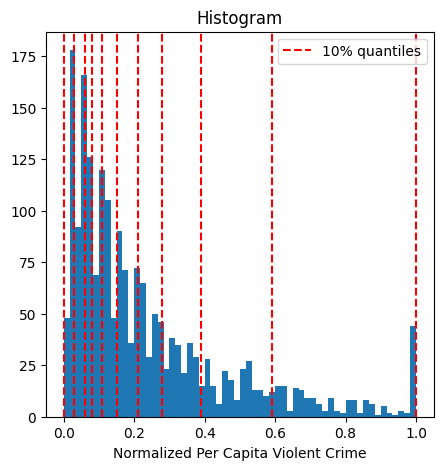

In [5]:
thres = [0] + [round(x, 2) for x in np.sort(y)[[int(len(y)/10*i) for i in range(1,10)]]] + [1]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for t in thres:
    ax.axvline(t, linestyle="--", c="r", label="10% quantiles"*int(t==0))
ax.hist(y, bins=60)
ax.set_xlabel("Normalized Per Capita Violent Crime")
ax.set_title("Histogram")
ax.legend()
plt.show()

By doing so, we create 10 groups based on the target value, where each group has the same number of samples.

## Evaluation functions

In [6]:
def estimate_scores(mapies, alpha, group_functions, score_functions,
                    n_train=2000,n_calib=2000,n_test=500, seed=1):
    """
    Sample a new data split, train the estimator on the training set, then
    fit the calibration on the new calibration set. The scores corresponding
    to ``score_functions`` are computing on each group of ``group_functions``.
    """
    (mapie_split, mapie_cqr, mapie_ccp) = mapies
    
    x_train, y_train, x_calib, y_calib, x_test, y_test = generate_data(
        seed=seed,
        n_train=n_train,n_calib=n_calib,n_test=n_test
    )

    mapie_split.fit(np.vstack([x_train, x_calib]), np.hstack([y_train, y_calib]))
    _, y_pis_split = mapie_split.predict(x_test, alpha=alpha)
    
    mapie_cqr.fit(x_train, y_train, X_calib=x_calib, y_calib=y_calib)
    _, y_pis_cqr = mapie_cqr.predict(x_test)
    
    mapie_ccp.fit(np.vstack([x_train, x_calib]), np.hstack([y_train, y_calib]))
    _, y_pis_ccp = mapie_ccp.predict(x_test)
   
    scores = np.zeros((3, len(score_functions), len(group_functions)))

    for i, y_pi in enumerate([y_pis_split, y_pis_cqr, y_pis_ccp]):
        for group_num, group_fn in enumerate(group_functions):
            x_filter = group_fn(x_test, y_test)
            for score_num, score_fn in enumerate(score_functions):
                scores[i,score_num, group_num] = score_fn(
                    y=y_test[x_filter],
                    lower=y_pi[:, 0, 0][x_filter],
                    upper=y_pi[:, 1, 0][x_filter]
                )
    
    return scores


def get_scores_n_trials(
        mapies, alpha, n_trials, group_functions, group_names,
        score_functions, score_names, n_train=2000, n_calib=2000, n_test=500,
    ):
    """
    Compute ``n_trials`` evaluation scores on different dataset splits.
    """

    scores = np.zeros((n_trials, 3, len(score_functions), len(group_functions)))

    for trial in tqdm(range(n_trials)):
        scores[trial,:,:,:] = estimate_scores(
            mapies, alpha, group_functions, score_functions,
            n_train, n_calib, n_test, trial
        )
        
    method_names = ["Split", "CQR", "CCP"]
    
    scores_df = pd.DataFrame()
    for group_num, group_name in enumerate([e for g in  group_names for e in g]):
        for method_num, method_name in enumerate(method_names):
            temp_df = pd.DataFrame(
                {
                    'Method': [method_name] * n_trials, 
                    'Group name' : [group_name] * n_trials, 
                }
            )
            for score_num, score_name in enumerate(score_names):
                temp_df[score_name] = scores[:,method_num, score_num, group_num]    

            scores_df = pd.concat([scores_df,temp_df], axis=0)
            
    return scores_df.reset_index(drop=True)

## Plotting functions

In [7]:
def plot_subplot(ax, y_test_sorted, y_pred_sorted, upper_pi, lower_pi, lw,
                 color_rgb, xlabel, ylabel, title, showlegend=False):
    color = mcolors.rgb2hex(color_rgb)
    ax.plot(y_test_sorted, y_pred_sorted, lw=lw, color='black', label="Prediction" if showlegend else "")
    ax.fill_between(y_test_sorted, upper_pi, lower_pi, color=color, alpha=0.3, label='Prediction interval' if showlegend else "")
    ax.plot(y_test_sorted, upper_pi, lw=lw, color=color)
    ax.plot(y_test_sorted, lower_pi, lw=lw, color=color)
    ax.plot([0, 1], [0, 1], lw=lw, color='black', linestyle='--', label="Perfect Prediction" if showlegend else "")
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


def plot_score_boxplot(ax, df, score_name, group_names, color_discrete_map):
    flatten_group_names = [item for sub in group_names for item in sub]
    for i, method in enumerate(["Split", "CQR", "CCP"]):
        df_method = df[df["Method"] == method]
        color = color_discrete_map[method]
        
        ax.boxplot(
            [df_method[df_method["Group name"] == g][score_name] for g in flatten_group_names],
            positions=np.arange(len(flatten_group_names)) + (i-1) * 0.2,
            widths=0.2, patch_artist=True,
            boxprops=dict(facecolor=color), medianprops=dict(color="black"),
            labels=[g if i == 1 else "" for g in flatten_group_names]
        )

    for g in group_names[1:]:
        ax.axvline(x=flatten_group_names.index(g[0]) - 0.5, color='black', linewidth=2)
    ax.tick_params(axis='x', rotation=-45)
    ax.set_xticks(np.arange(len(flatten_group_names)))
    ax.set_xticklabels(flatten_group_names, ha='left', rotation_mode='anchor')


In [8]:
def plot_results(mapies, alpha, n_trials, group_functions, group_names, score_functions, score_names, n_train=2000, n_calib=2000, n_test=500):
    (mapie_split, mapie_cqr, mapie_ccp) = mapies
    x_train, y_train, x_calib, y_calib, x_test, y_test = generate_data(n_train=n_train, n_calib=n_calib, n_test=n_test)

    sort_order = np.argsort(y_test)
    x_test_sorted = x_test[sort_order, :]
    y_test_sorted = y_test[sort_order]

    cp = plt.get_cmap('tab10').colors
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.grid'] = False

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    # ========================== Split ==========================
    mapie_split.fit(np.vstack([x_train, x_calib]), np.hstack([y_train, y_calib]))
    y_pred_split, y_pis_split = mapie_split.predict(x_test_sorted, alpha=alpha)
    split_lower = y_pis_split[:, 0, 0]
    split_upper = y_pis_split[:, 1, 0]
    plot_subplot(axes[0], y_test_sorted, y_pred_split, split_upper, split_lower, 1, cp[0], "True Price", "Predicted Price", "Split", showlegend=True)

    # ========================== CQR ==========================
    mapie_cqr.fit(x_train, y_train, X_calib=x_calib, y_calib=y_calib)
    y_pred_cqr, y_pi_cqr = mapie_cqr.predict(x_test_sorted)
    cqr_lower = y_pi_cqr[:, 0, 0]
    cqr_upper = y_pi_cqr[:, 1, 0]
    plot_subplot(axes[1], y_test_sorted, y_pred_cqr, cqr_upper, cqr_lower, 1, cp[1], "True Price", "Predicted Price", "CQR")

    # ========================== CCP ==========================
    mapie_ccp.fit(np.vstack([x_train, x_calib]), np.hstack([y_train, y_calib]))
    y_pred_ccp, y_pis_ccp = mapie_ccp.predict(x_test_sorted)
    ccp_lower = y_pis_ccp[:, 0, 0]
    ccp_upper = y_pis_ccp[:, 1, 0]
    plot_subplot(axes[2], y_test_sorted, y_pred_ccp, ccp_upper, ccp_lower, 1, cp[2], "True Price", "Predicted Price", "CCP")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc="upper right")

    plt.subplots_adjust(top=0.95, right=0.9)
    plt.show()

    if n_trials:
        # ========================== Compute Scores on many tries ==========================
        scores_df = get_scores_n_trials(mapies, alpha, n_trials, group_functions, group_names, score_functions, score_names, n_train, n_calib, n_test)
        # ============================ Plot results ============================
        for score_name in score_names:
            fig, ax = plt.subplots(figsize=(30, 10))

            color_discrete_map = dict(zip(["Split", "CQR", "CCP"], [mcolors.rgb2hex(c) for c in cp[:3]]))

            plot_score_boxplot(ax, scores_df, score_name, group_names, color_discrete_map)

            if score_name == "Coverage":
                ax.axhline(1 - alpha, color='red', linewidth=3)

            ax.set_title(score_name, fontsize=22)
            ax.set_xlabel("Groups", fontsize=20)
            ax.set_ylabel(score_name, fontsize=20)
            ax.tick_params(axis='both', which='major', labelsize=20)
            
            legend_handles = [mpatches.Patch(color=color, label=method) for method, color in color_discrete_map.items()]
            fig.legend(handles=legend_handles, loc='upper right', fontsize=18)

            plt.tight_layout()
            plt.show()

        return scores_df

## Evaluation methods and configuration

In [9]:
# Number of trials, to reduce stochasticity in the evaluation
N_TRIALS = 10

# scores functions
coverage_funct = lambda y, lower, upper : np.mean((lower <= y) & (y <= upper))
width_funct = lambda y, lower, upper : np.mean(np.abs(upper-lower))
score_functions = [coverage_funct, width_funct]
score_names = ["Coverage", "Width"]

# Groups functions: the scores will be evaluated on each one of these groups.
thres = thres = [0] + [round(x, 2) for x in np.sort(y)[[int(len(y)/10*i) for i in range(1,10)]]] + [1]

# index of the 4 columns of interest:
# 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp'
group_cols = [4, 5, 6, 7]

group_functions = (
    # all dataset, for marginal evaluation
    [lambda x, y: np.ones(len(x)).astype(bool)]
    # 10 target groups
    + [lambda x, y, i=i : np.logical_and(y>=thres[i],  y <= thres[i+1]) for i in range(10)]
    # groups on ethnicity features
    + [lambda x, y, c=c, q1=q1, q2=q2 : np.logical_and(
        x[:, c] >= np.sort(X_scaled[:,c])[int(len(X_scaled)*q1)],
        x[:, c] <= np.sort(X_scaled[:,c])[int(len(X_scaled)*q2)-1])
        for c in group_cols
        for (q1, q2) in zip([0, 0.25, 0.5, 0.75], [0.25, 0.5, 0.75, 1])
    ]
)
group_names = (
    [["MARGINAL"]] 
    + [[f"Crime: {thres[i]} - {thres[i+1]}" for i in range(10)]]
    + [
        [
            f"{col_names[c]} : {q1}-{q2}%" 
            for (q1, q2) in zip([0, 25, 50, 75], [25, 50, 75, 100])
        ]
        for c in group_cols
    ]
)


## Model used for predictions

In [10]:
# Define the model
estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=random_state,
    verbose=-1,
)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [8, 12, 16],
    'n_estimators': [50, 100, 150, 200],
    'num_leaves': [14, 21, 28, 35]
}

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=random_state
)

# Perform the random search
random_search.fit(X_scaled, y)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", -random_search.best_score_)

estimator = random_search.best_estimator_

Best parameters found:  {'num_leaves': 28, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}
Best cross-validation score:  0.0856611994572579


# Experiments and results:

In [11]:
ALPHA = 0.2
n_train, n_calib = 650, 650

# PredefinedSplit is used to make sure that each method is trained
# and calibrated on the same data, to have a fair comparison
cv = PredefinedSplit([-1]*n_train + [1]*n_calib)

# ================= Split =================
mapie_split = MapieRegressor(
    estimator, method="base", cv=cv,
    conformity_score=AbsoluteConformityScore(sym=False)
)

# ================= CQR =================
mapie_cqr = MapieQuantileRegressor(estimator, alpha=ALPHA)

---

## 1. Using ``GaussianCCP`` calibrator for adaptativity <u>without prior knowledge on the dataset or biases</u>

In [12]:
calibrator_1 = GaussianCCP(40, 7, normalized=True, reg_param=1e-4)

mapie_ccp = SplitCPRegressor(
    estimator, calibrator_1, cv=cv, alpha=ALPHA,
    conformity_score=AbsoluteConformityScore(sym=False),
)

### Plotting the result

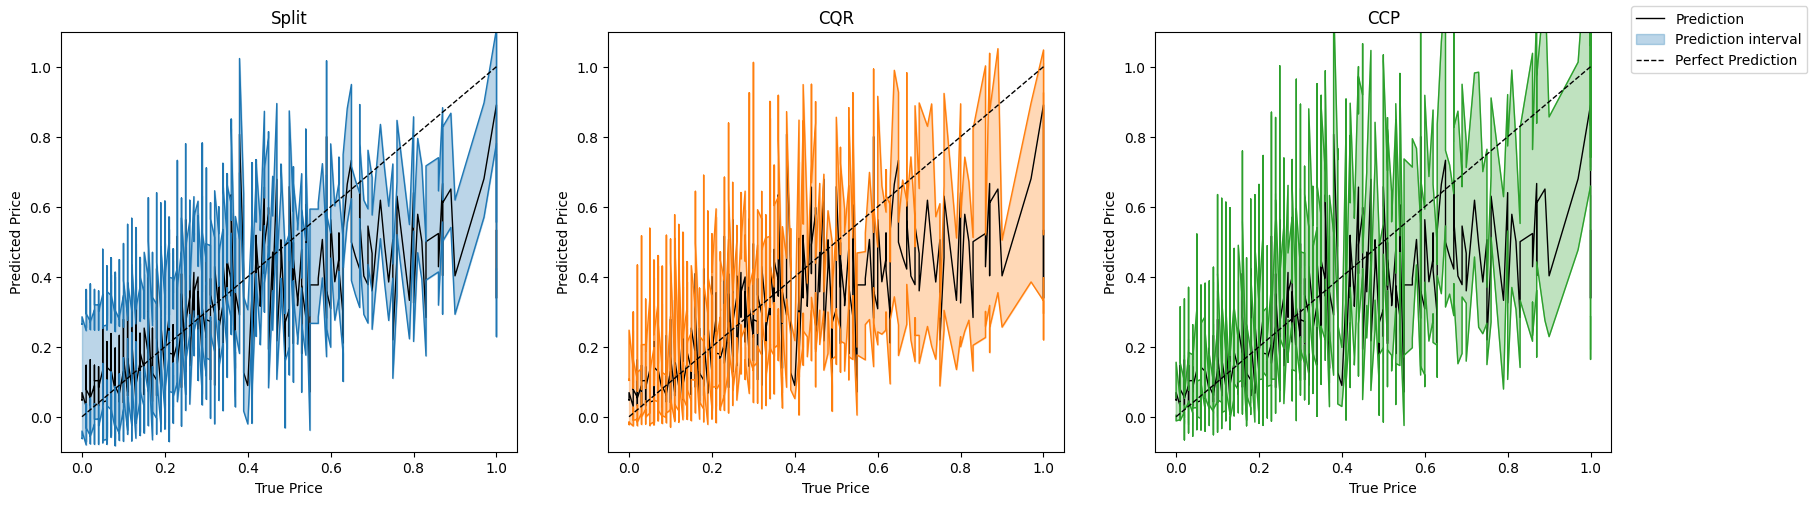

100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


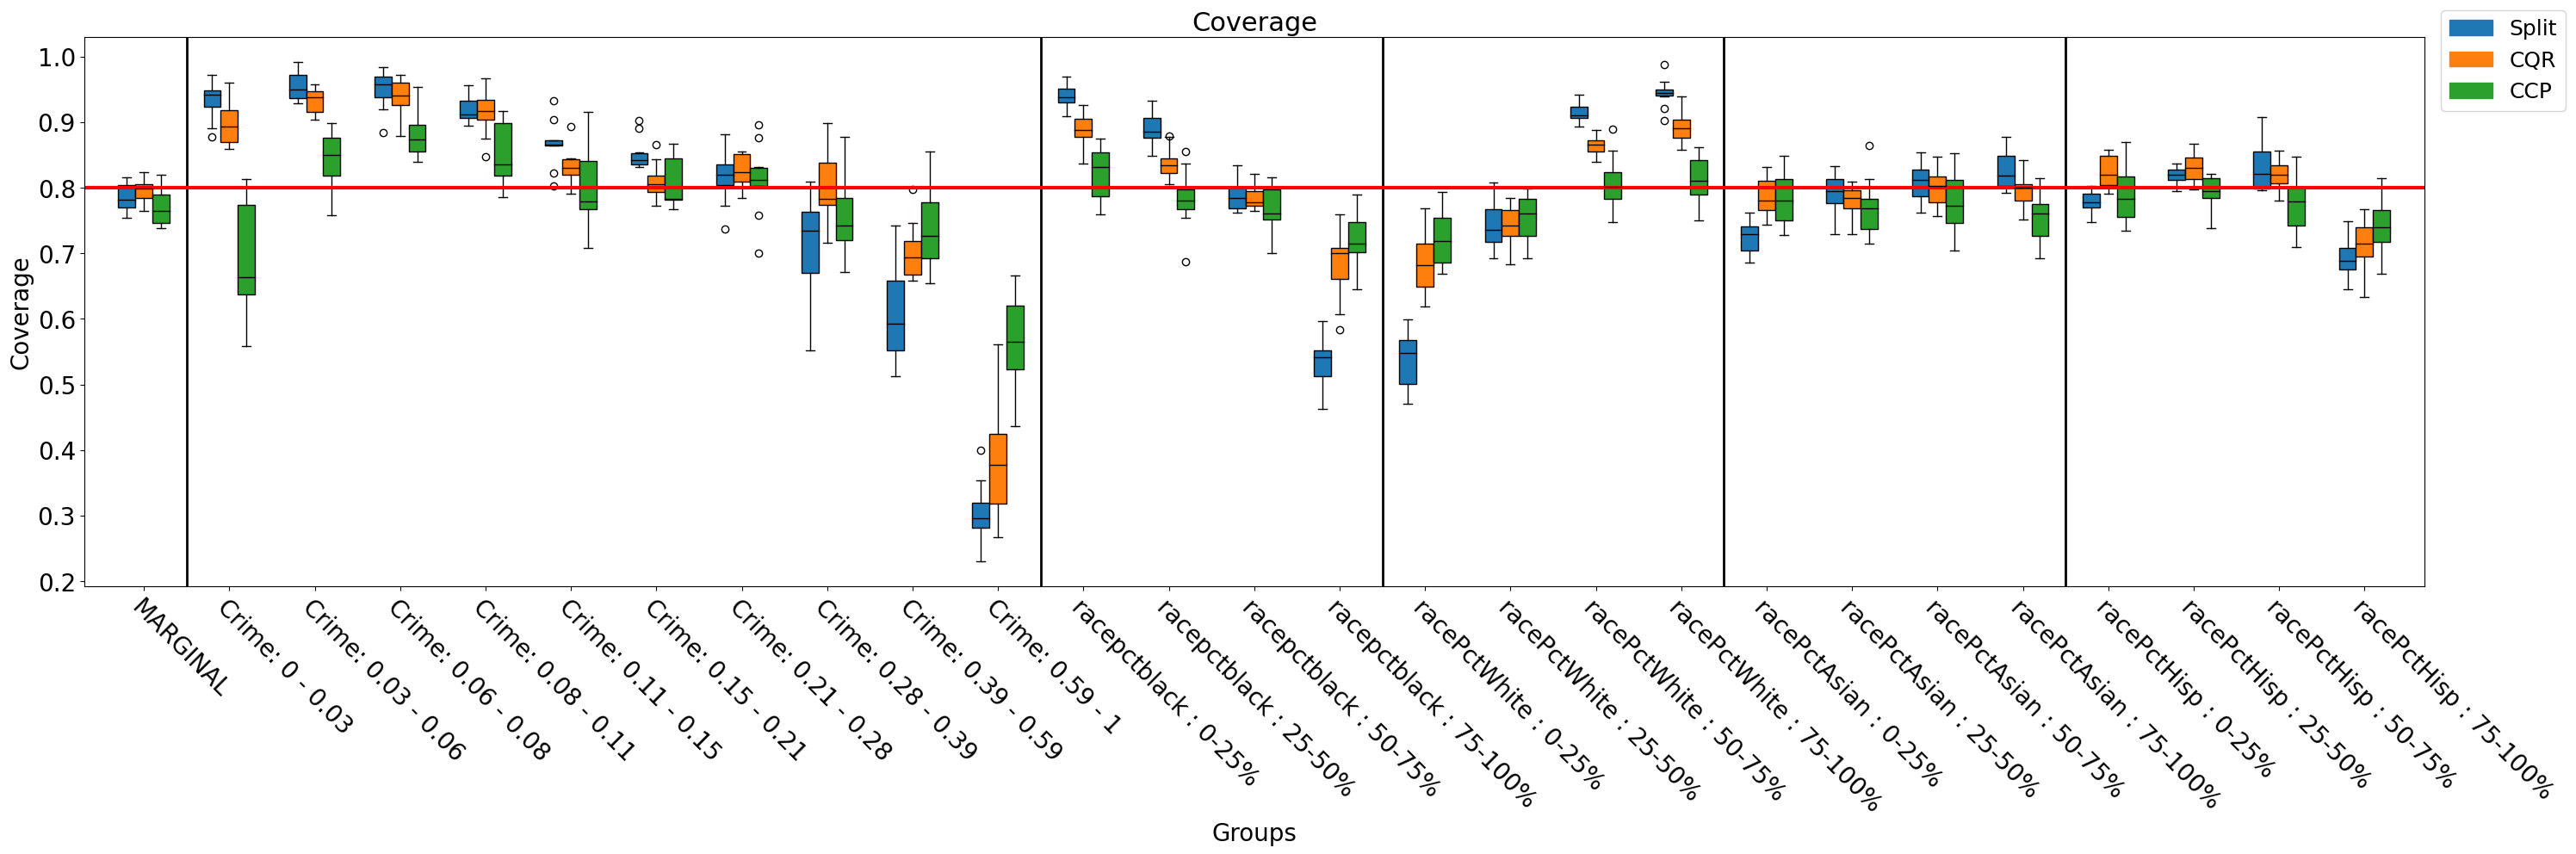

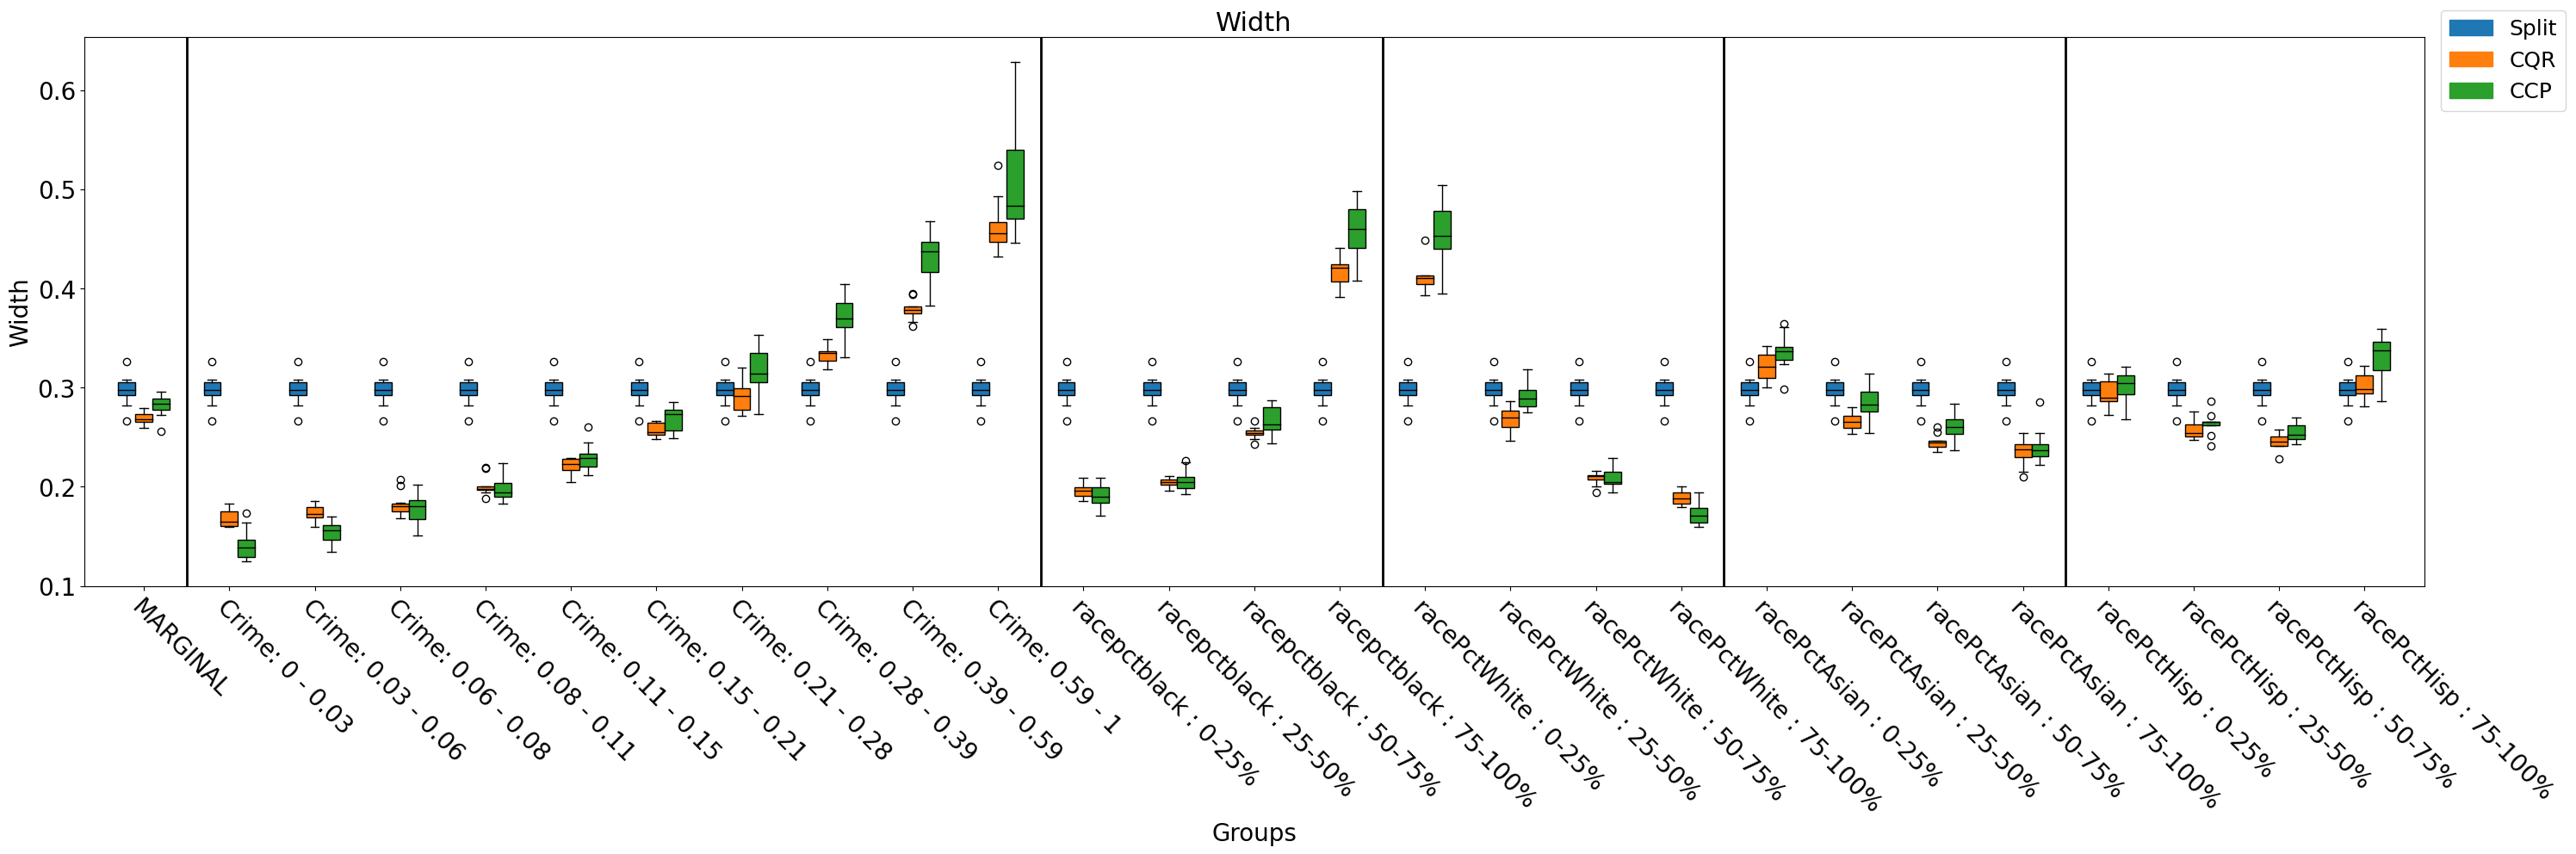

In [13]:
df = plot_results(
    [mapie_split, mapie_cqr, mapie_ccp], ALPHA, N_TRIALS,
    group_functions, group_names, score_functions, score_names,
    n_train=n_train, n_calib=n_calib, n_test=1994-n_train-n_calib
)

- The method which is the more adaptative is the one with the most constant coverage.
- Here, the ``CCP`` method is the best one. We can see that the basic ``Split`` method has a strong over-coverage for small target values, and under-coverage for big target values. Moreover, it seems to have a <u>strong bias</u> on the ``'racepctblack'`` and ``'racePctWhite'``.
- The ``CQR`` method is better than the ``Split`` but suffers from the same issues.

$\to$ We managed, with the ``CCP`` method, to have almost a <u>homogenous coverage</u> on the target value, and a much <u>smaller bias on the ethnicity groups</u>.

---

## 2. Using ``CustomCCP`` calibrator for adaptativity <u>with prior knowledge about the biases</u> we want to avoid
We saw previously, that there was a strong bias on the ethnicity features (with over or under coverage for some values).

$\to$ We can use this information in the ``CCP`` calibrator, to fix it. Let's use a ``CustomCCP`` calibrator, with those features, to guarantee a homogenous coverage on those.
We could just add, as custom functions definition, indicatrice functions for each of the 4 groups (split using Q1, mediane and Q3 values), for each ethnicity feature. 

However, as the coverage seems to be proportional to the ethnicity value, we will also pass the specific ``X`` value.

In [14]:
calibrator_2 = CustomCCP(
    [  # We add the ethnicity feature value for each of the 4 ethnicity, to make sure there is no bias.
        lambda X, c=c, q1=q1, q2=q2 : X[:, c] * np.logical_and(
            X[:, c] >= np.sort(X_scaled[:, c])[int(len(X_scaled)*q1)],
            X[:,c] <= np.sort(X_scaled[:, c])[int(len(X_scaled)*q2)-1]
        ) 
        for c in group_cols
        for (q1, q2) in zip([0, 0.25, 0.5, 0.75], [0.25, 0.5, 0.75, 1])
    ],
    normalized=True,
    bias=True,
    reg_param = 1e-4,
)

mapie_ccp = SplitCPRegressor(
    estimator, calibrator_2, cv=cv, alpha=ALPHA,
    conformity_score=AbsoluteConformityScore(sym=False),
)

### Plotting the result

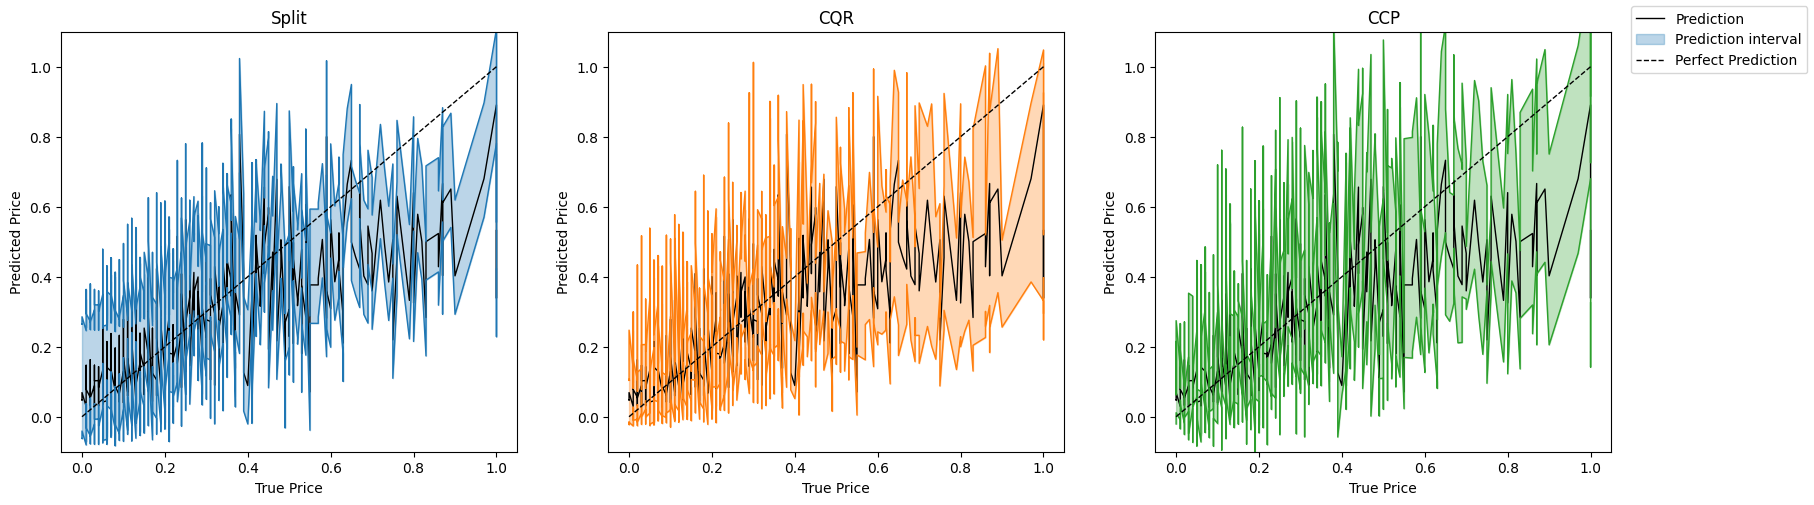

100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


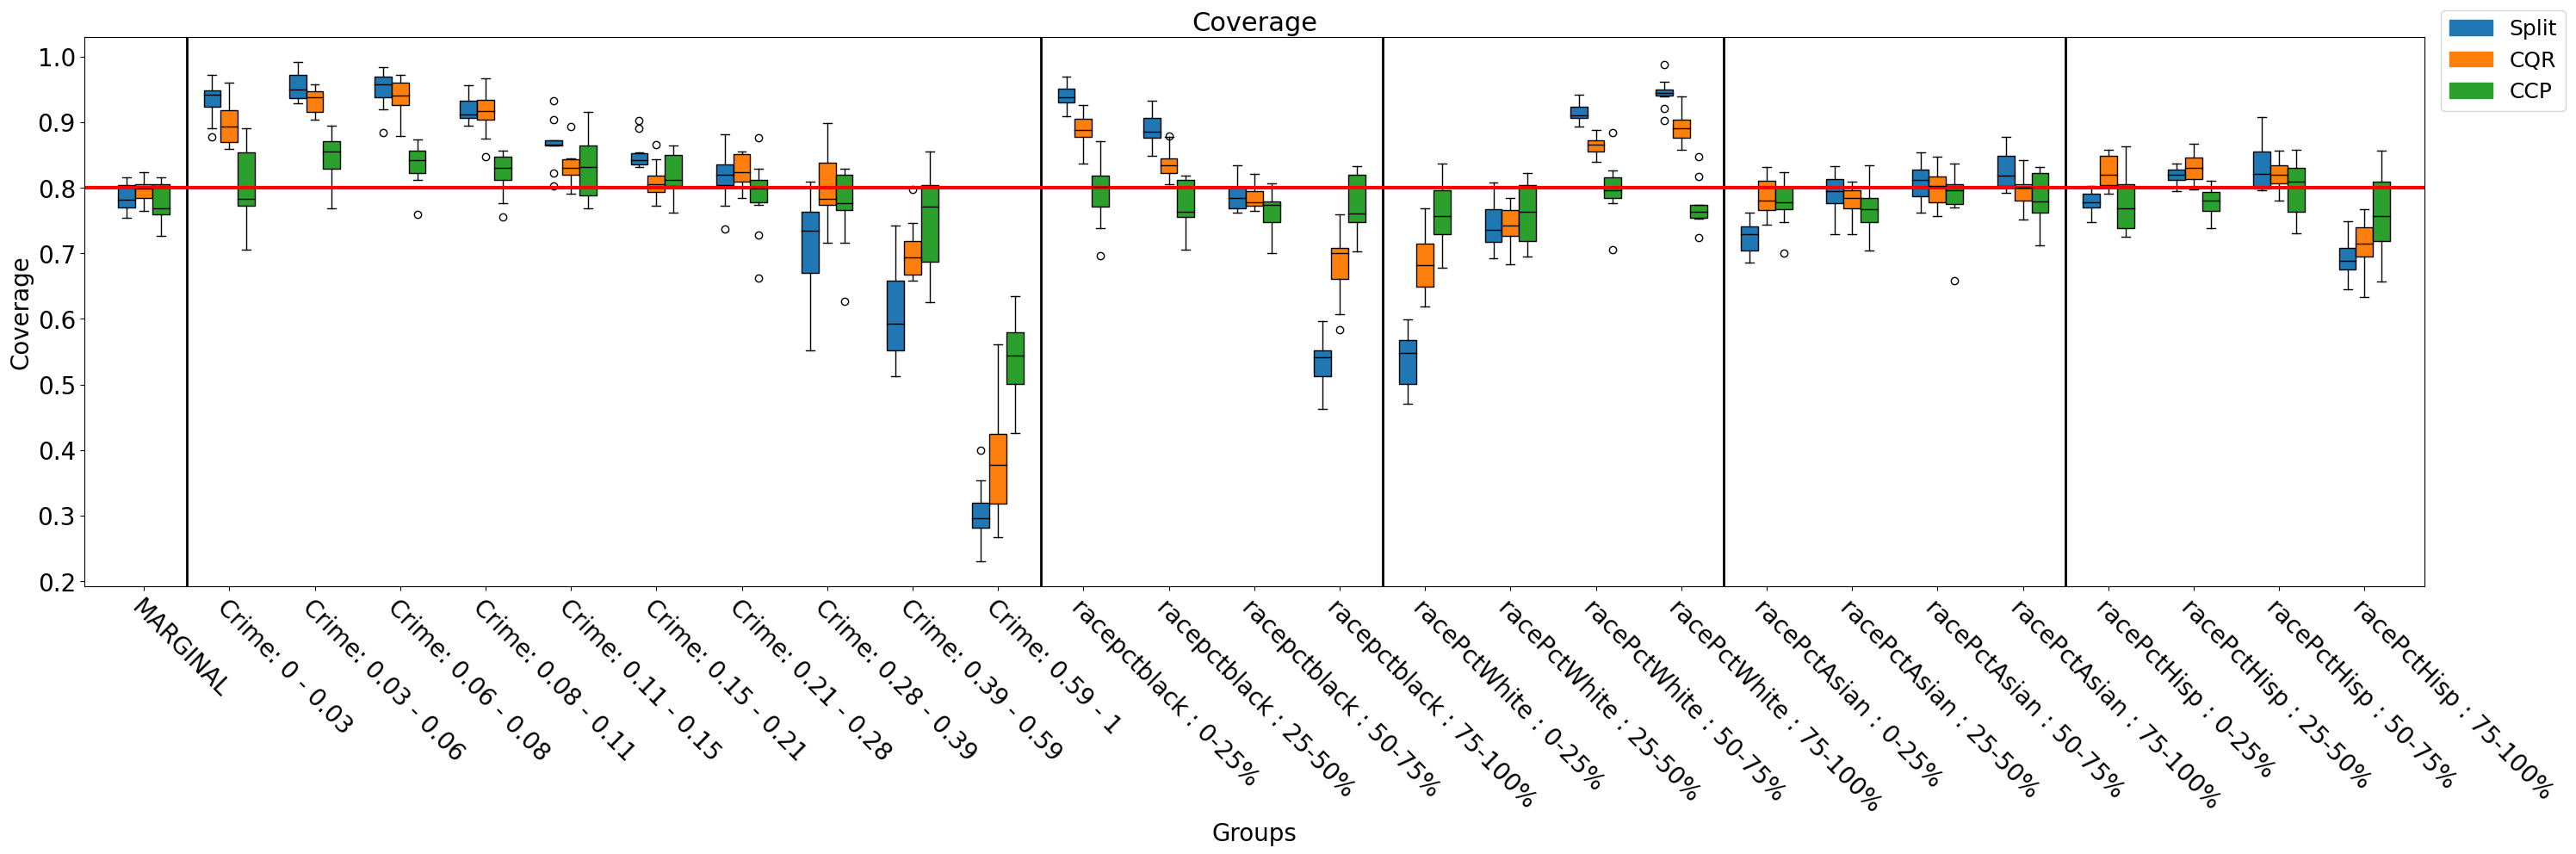

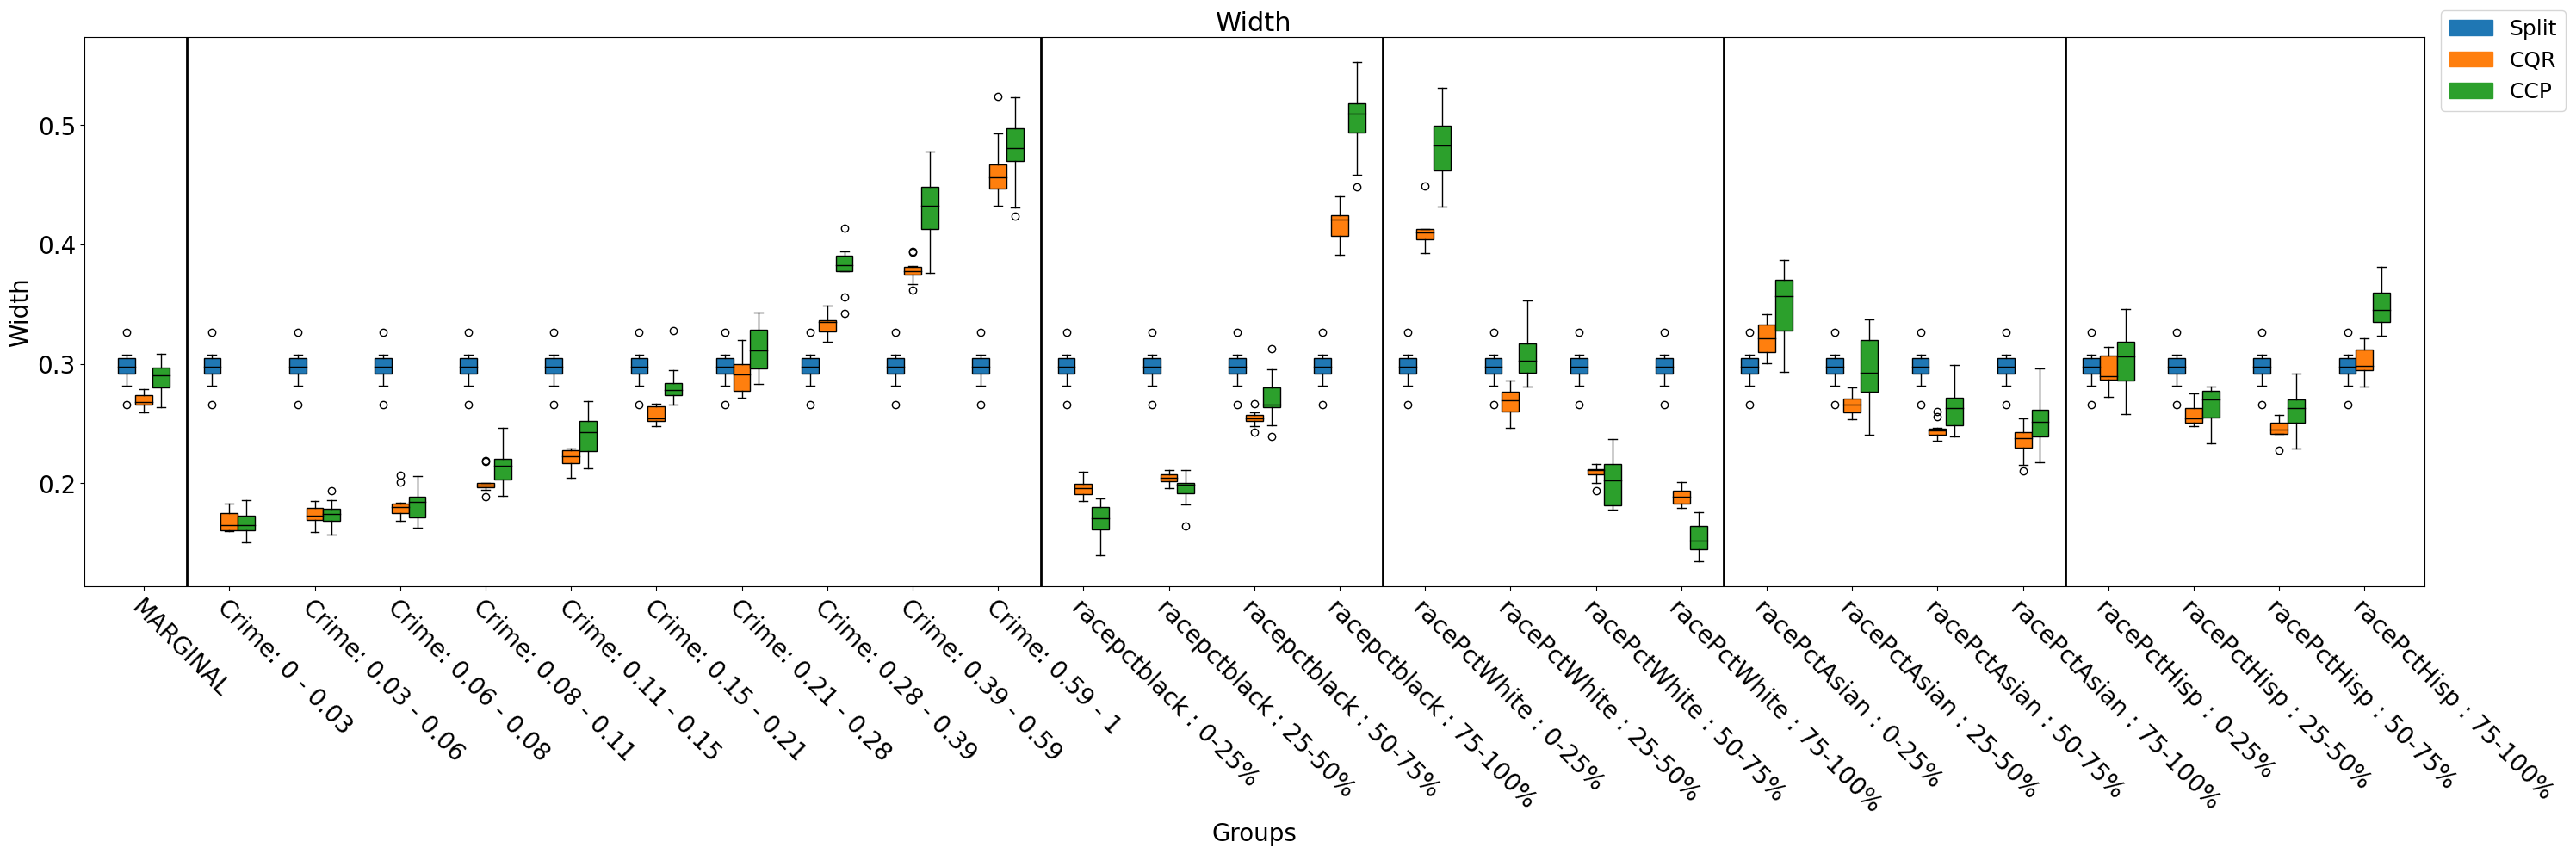

In [15]:
df = plot_results(  
    [mapie_split, mapie_cqr, mapie_ccp], ALPHA, N_TRIALS,
    group_functions, group_names, score_functions, score_names,
    n_train=n_train, n_calib=n_calib, n_test=1994-n_train-n_calib
)

1) As we expected, the coverage is now <u>homogenous on the ethnicity groups</u>. To achieve it, the prediction intervals are now even wider than before for previously under-covered samples, and smaller on previously over-covered samples. 

$\to$ The ``CCP`` method can guarantee a homogenous coverage on groups of interest (thus <u>remove bias</u>), by giving to the calibrator those groups, using ``CustomCCP`` calibrators.

2) It turned out that, over all the dataset features, the 4 ethnicity features we identified were the ones with the biggest bias.

$\to$ Fixing this bias, almost fixed the non-homogeneity of the coverage, on the target value.

3) <u>Next steps</u>: the only issue to achieve an almost perfect adaptativity, is to fix the under-coverage for the biggest 10% target crime values. One idea may be to combine the two approachs we used, or add a new column to the calibrator, with the ``y_pred`` value (example: adding ``Polynomial([4], variable="y_pred")``) to have a bigger interval for high predictions, without changing too much the smaller predictions.